# Experiments

In [6]:
from collections import defaultdict
from timeit import default_timer as timer

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import datasets
from learners import \
    OnlineGradientDescent, \
    DimensionFreeExponentiatedGradient, AdaptiveNormal, \
    KT, ContextTreeWeighting, \
    Addition, AddingVectorBettings, Mixture
from learners import MarkovSideInformation, QuantizedHint
from problems import LinearRegressionWithAbsoluteLoss
from quantizer import Quantizer, get_standard_vector

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
problem = LinearRegressionWithAbsoluteLoss()

dataset = datasets.BeijingPM2pt5(
    root='../',
    standardize=False,
    rescale=False,
    bias=True,
    normalize=True,
    batch_normalize=False)
dim = dataset.X.shape[1]

# data
X, y = dataset.X, dataset.y
data = X, y

In [3]:
X.shape

(43800, 7)

In [4]:
depths_markov = [0] + list(range(1, 13, 2))

In [6]:
# OGD with Markov side information
ogds = defaultdict(lambda: defaultdict(dict))
# lr_scales = np.array([1.5 ** n for n in range(20)])  # cpuSmall, YPMSD
lr_scales = np.array([1.5 ** n for n in np.arange(5, 25)])  # Houses
for i in range(dim):
    for depth in depths_markov:
        for lr_scale in lr_scales:
            ogds[i][depth][lr_scale] = OnlineGradientDescent(
                dim=dim,
                lr_scale=lr_scale,
                problem=problem,
                side_information=MarkovSideInformation(
                    depth=depth,
                    quantizer=Quantizer(quantizer_vector=get_standard_vector(dim, i)),
                ),
            ).fit(data)
        print(depth, end=' ')
    print()

0 1 3 5 7 9 11 
0 1 3 5 7 9 11 
0 1 3 5 7 9 11 
0 1 3 5 7 9 11 
0 1 3 5 7 9 11 
0 1 3 5 7 9 11 
0 1 3 5 7 9 11 


In [7]:
init_wealth = 10 ** (-5.)

# with Markov side information
kt_markovs = defaultdict(dict)
suboptimal_kt_markovs = defaultdict(dict)
dfeg_markovs = defaultdict(dict)
adanorm_markovs = defaultdict(dict)
for i in range(dim):
    for depth in depths_markov:
        dfeg_markovs[i][depth] = DimensionFreeExponentiatedGradient(
            dim=dim,
            problem=problem,
            side_information=MarkovSideInformation(
                depth,
                quantizer=Quantizer(quantizer_vector=get_standard_vector(dim, i)))
        ).fit(data)

        adanorm_markovs[i][depth] = AdaptiveNormal(
            dim=dim,
            problem=problem,
            side_information=MarkovSideInformation(
                depth,
                quantizer=Quantizer(quantizer_vector=get_standard_vector(dim, i)))
        ).fit(data)

        kt_markovs[i][depth] = KT(
            dim=dim,
            init_wealth=init_wealth,
            problem=problem,
            side_information=MarkovSideInformation(
                depth,
                quantizer=Quantizer(quantizer_vector=get_standard_vector(dim, i)))
        ).fit(data)

        print(depth, end=' ')
    print()

0 1 3 5 7 9 11 
0 1 3 5 7 9 11 
0 1 3 5 7 9 11 
0 1 3 5 7 9 11 
0 1 3 5 7 9 11 
0 1 3 5 7 9 11 
0 1 3 5 7 9 11 


In [9]:
# with hint
coin_hint = defaultdict(dict)
for i in range(dim):
    coin_hint[i] = KT(dim=dim,
                      init_wealth=init_wealth,
                      problem=problem,
                      side_information=QuantizedHint(
                          quantizer=Quantizer(quantizer_vector=get_standard_vector(dim, i)))
                      ).fit(data)
    print(i, end=' ')


0 1 2 3 4 5 6 

In [10]:
# with CTW
times = []
ctws = defaultdict(dict)
max_depths_ctw = range(1, 13, 2)
for i in range(dim):
    print("quantizer {}".format(i + 1))
    for max_depth in max_depths_ctw:
        start = timer()
        ctws[i][max_depth] = ContextTreeWeighting(
            dim=dim,
            init_wealth=init_wealth,
            max_depth=max_depth,
            problem=problem,
            quantizer=Quantizer(quantizer_vector=get_standard_vector(dim, i)),
        ).fit(data)
        times.append(timer() - start)
        print(max_depth, times[-1])

quantizer 0
1 3.7229680079999525
3 6.38691625499996
5 8.847379302000036
7 11.773583850000023
9 14.721846013000004
11 33.010934459000055
quantizer 1
1 3.8993691980001586
3 6.828159916999994
5 8.936653145000037
7 13.378897456999994
9 16.143367666999893
11 17.333851292999952
quantizer 2
1 3.719496184000036
3 6.961154196000052
5 9.353046038000002
7 11.94895186000008
9 14.196872700000085
11 17.78059981399997
quantizer 3
1 3.9430197909998697
3 6.3315127700000176
5 8.856105857000102
7 11.478332519999867
9 14.473843421000083
11 18.311782783999888
quantizer 4
1 3.841340442000046
3 6.447115979000046
5 9.024230023999962
7 11.467690651000112
9 14.595832298000005
11 16.64604529799999
quantizer 5
1 3.8606462410000404
3 6.363353390999919
5 8.870580671000198
7 11.547774940999943
9 14.268743061000123
11 18.564627393000137
quantizer 6
1 4.336854887999834
3 7.008009580999897
5 9.178694447999987
7 11.427347776000033
9 14.751529032000008
11 16.768209930000012


## Combine algorithms

In [12]:
# combining Markovs over dimensions
depths_combine_markovs_dims = range(1, 13, 2)
add_markovs_over_dims = dict()
mix_markovs_over_dims = dict()
for depth in depths_combine_markovs_dims:
    algorithms = [
        KT(
            dim=dim,
            init_wealth=init_wealth,
            problem=problem,
            side_information=MarkovSideInformation(
                depth,
                quantizer=Quantizer(quantizer_vector=get_standard_vector(dim, i)))
        )
        for i in range(dim)]
    add_markovs_over_dims[depth] = Addition(dim=dim, algorithms=algorithms).fit(data)
    mix_markovs_over_dims[depth] = Mixture(dim, algorithms, init_wealth=init_wealth, weights=None).fit(data)
    print(depth, end=' ')

1 3 5 7 9 11 

In [13]:
# combining Markovs over depths and dimensions
max_depths_combine_markovs_depths_dims = range(1, 13, 2)
add_markovs_over_depths_dims = dict()
mix_markovs_over_depths_dims = dict()
for depth in max_depths_combine_markovs_depths_dims:
    algorithms = [
        KT(
            dim=dim,
            init_wealth=init_wealth,
            problem=problem,
            side_information=MarkovSideInformation(
                depth,
                quantizer=Quantizer(quantizer_vector=get_standard_vector(dim, i)))
        )
        for d in range(depth) for i in range(dim)]
    add_markovs_over_depths_dims[depth] = Addition(dim, algorithms).fit(data)
    mix_markovs_over_depths_dims[depth] = Mixture(dim, algorithms, init_wealth=init_wealth, weights=None).fit(data)
    print(depth, end=' ')

1 3 5 7 9 11 

In [14]:
# combining CTWs over dimensions
max_depths_combine_ctws_dims = range(1, 13, 2)
add_ctws_over_dims = dict()
mix_ctws_over_dims = dict()

for max_depth in max_depths_combine_ctws_dims:
    algorithms = [
        ContextTreeWeighting(
            dim=dim,
            init_wealth=init_wealth,
            quantizer=Quantizer(get_standard_vector(dim, i)),
            max_depth=max_depth,
            problem=problem)
        for i in range(dim)]
    add_ctws_over_dims[max_depth] = Addition(dim, algorithms).fit(data)
    mix_ctws_over_dims[max_depth] = Mixture(dim, algorithms, init_wealth=init_wealth, weights=None).fit(data)
    print(max_depth, end=' ')

1 3 5 7 9 11 

In [120]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10, 6)
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markeredgecolor'] = mpl.colors.colorConverter.to_rgba('k', alpha=.45)

# markers = [(i, j, 0) for i in range(2, 10) for j in range(1, 3)]
markers = [',', 'o', 'v', 's', 'p', '*', 'P', 'X', 'D']

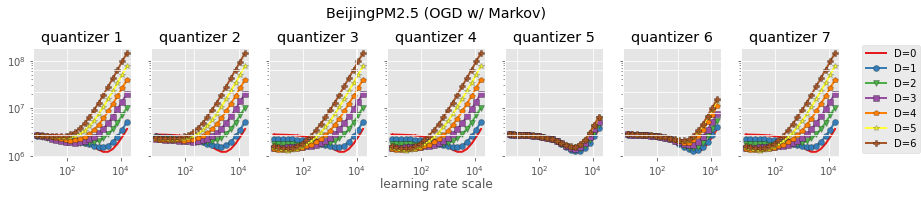

In [116]:
fig, ax = plt.subplots(nrows=1,
                       ncols=dim,
                       figsize=(14, 2),
                       sharey='all')

lines = []
for i in range(dim):
    lines = []
    ax[i].set_prop_cycle('color',[plt.cm.Set1(k) for k in np.linspace(0, 1, 9)])
    for (j, depth) in enumerate(depths_markov):
        lines.append(
            ax[i].plot(lr_scales,
                       [ogds[i][depth][lr_scale].cum_loss for lr_scale in lr_scales],
                       marker=markers[j], label='D={}'.format(depth))[0]
        )

    # ax[i].legend(ncol=1)
    ax[i].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    ax[i].set_title('quantizer {}'.format(i + 1))
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')

labels = ['D={}'.format(i) for i in range(dim)]
fig.legend(
    handles=lines,                # The line objects
    labels=labels,        # The labels for each line
    loc='center right',   # Position of legend
    ncol=1,
    borderaxespad=0.1,    # Small spacing around legend box
)
plt.subplots_adjust(right=0.925)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.title('{} (OGD w/ Markov)'.format(dataset.name), pad=30)
plt.xlabel("learning rate scale")
# plt.ylabel("cumulative loss")
plt.savefig('{}-ogd.pdf'.format(dataset.name),
            bbox_inches='tight',
            transparent=False)

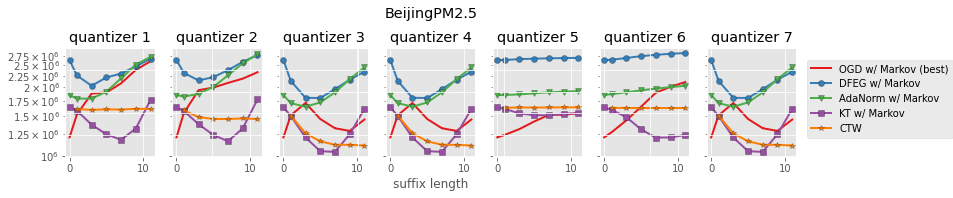

In [117]:
fig, ax = plt.subplots(nrows=1,
                       ncols=dim,
                       figsize=(14, 2),
                       sharey='all')
lines = []
for i in range(dim):
    ax[i].set_prop_cycle('color',[plt.cm.Set1(k) for k in np.linspace(0, 1, 9)])
    l1 = ax[i].plot(depths_markov, [np.min([ogds[i][depth][lr_scale].cum_loss for lr_scale in lr_scales]) for depth in depths_markov],
                    marker=markers[0])[0]
    l2 = ax[i].plot(depths_markov,
                    [dfeg_markovs[i][depth].cum_loss for depth in depths_markov],
                    marker=markers[1])[0]
    l3 = ax[i].plot(depths_markov,
                    [adanorm_markovs[i][depth].cum_loss for depth in depths_markov],
                    marker=markers[2])[0]
    l4 = ax[i].plot(depths_markov,
                    [kt_markovs[i][depth].cum_loss for depth in depths_markov],
                    marker=markers[3])[0]
    # l5 = ax[i].axhline(coin_hint[i].cum_loss,
    #                    marker=markers[4])
    l6 = ax[i].plot(max_depths_ctw,
                    [ctws[i][max_depth].cum_loss for max_depth in max_depths_ctw],
                    marker=markers[5])[0]
    lines = [l1, l2, l3, l4,
             # l5,
             l6]
    ax[i].set_title('quantizer {}'.format(i + 1))
    ax[i].set_yscale('log')

labels = ['OGD w/ Markov (best)',
          'DFEG w/ Markov', 'AdaNorm w/ Markov',
          'KT w/ Markov',
          # 'KT w/ hint',
          'CTW']
fig.legend(
    handles=lines,                # The line objects
    labels=labels,        # The labels for each line
    loc="center right",   # Position of legend
    borderaxespad=0.1,    # Small spacing around legend box
)
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.subplots_adjust(right=0.85)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.title('{}'.format(dataset.name), pad=30)
plt.xlabel("suffix length")
# plt.ylabel("cumulative loss", labelpad=20)
plt.savefig('{}-statewise.pdf'.format(dataset.name),
            pad_inches=0.2,
            bbox_inches='tight',
            transparent=False)

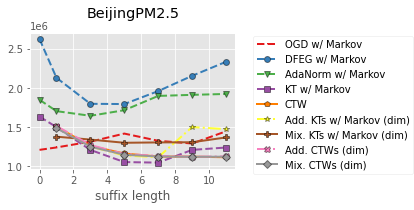

In [122]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 2.5))
ax.set_prop_cycle('color',[plt.cm.Set1(k) for k in np.linspace(0, 1, 9)])
l0 = ax.plot(depths_markov, [np.min([np.min([ogds[i][depth][lr_scale].cum_loss
                                             for lr_scale in lr_scales])
                                     for i in range(dim)])
                             for depth in depths_markov],
             linestyle='--',
             marker=markers[0])[0]
l1 = ax.plot(depths_markov, [np.min([dfeg_markovs[i][depth].cum_loss
                                     for i in range(dim)])
                             for depth in depths_markov],
             linestyle='--',
             marker=markers[1])[0]
l2 = ax.plot(depths_markov, [np.min([adanorm_markovs[i][depth].cum_loss
                                     for i in range(dim)])
                             for depth in depths_markov],
             linestyle='--',
             marker=markers[2])[0]
l3 = ax.plot(depths_markov, [np.min([kt_markovs[i][depth].cum_loss
                                     for i in range(dim)])
                             for depth in depths_markov],
             linestyle='--',
             marker=markers[3])[0]
# l5 = plt.axhline(np.min([coin_hint[i].cum_loss
#                     for i in range(dim)]),
#                  linestyle='--')
l4 = ax.plot(max_depths_ctw, [np.min([ctws[i][max_depth].cum_loss
                                      for i in range(dim)])
                              for max_depth in max_depths_ctw],
             marker=markers[4])[0]

l5 = ax.plot(depths_combine_markovs_dims, [add_markovs_over_dims[depth].cum_loss
                                           for depth in depths_combine_markovs_dims],
             linestyle='-.',
             marker=markers[5])[0]
l6 = ax.plot(depths_combine_markovs_dims, [mix_markovs_over_dims[depth].cum_loss
                                           for depth in depths_combine_markovs_dims],
             marker=markers[6],
             linestyle='solid')[0]
# l8 = plt.plot(depths_combine_markovs_dims, [add_markovs_over_depths_dims[depth].cum_loss
#                                        for depth in depths_combine_markovs_dims],
#               marker=markers[7],
#               linestyle='-.')[0]
# l9 = plt.plot(depths_combine_markovs_dims, [mix_markovs_over_depths_dims[depth].cum_loss
#                                        for depth in depths_combine_markovs_dims],
#               marker=markers[8],
#               linestyle='solid')[0]
l7 = ax.plot(max_depths_combine_ctws_dims, [add_ctws_over_dims[depth].cum_loss
                                            for depth in depths_combine_markovs_dims],
             marker=markers[7],
             linestyle='-.')[0]
l8 = ax.plot(max_depths_combine_ctws_dims, [mix_ctws_over_dims[depth].cum_loss
                                            for depth in depths_combine_markovs_dims],
             marker=markers[8],
             linestyle='solid')[0]
from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
lines = [l0, l1, l2, l3, l4,
         l5, l6, l7, l8]
labels = ['OGD w/ Markov',
          'DFEG w/ Markov', 'AdaNorm w/ Markov',
          'KT w/ Markov',
          # 'KT w/ hint',
          'CTW',
          'Add. KTs w/ Markov (dim)', 'Mix. KTs w/ Markov (dim)',
          # 'Add. KTs w/ Markov (dim,depth)', 'Mix. KTs w/ Markov (dim,depth)',
          'Add. CTWs (dim)', 'Mix. CTWs (dim)']
legend = fig.legend(
    handles=lines,                # The line objects
    labels=labels,        # The labels for each line
    loc='center right',   # Position of legend
    ncol=1,
    borderaxespad=0.1,    # Small spacing around legend box
)
plt.subplots_adjust(right=0.6)

frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_alpha(0.5)
plt.title(dataset.name, pad=15)
plt.xlabel("suffix length")
# plt.ylabel("cumulative loss")
plt.savefig('{}-summary.pdf'.format(dataset.name),
            bbox_inches='tight',
            transparent=False)

In [130]:
dataset_name = dataset.name

In [131]:
ogds_cum_loss = dict()
for dim in ogds.keys():
    ogds_cum_loss[dim] = dict()
    for depth in ogds[dim].keys():
        ogds_cum_loss[dim][depth] = dict()
        for lr_scale in ogds[dim][depth].keys():
            ogds_cum_loss[dim][depth][lr_scale] = ogds[dim][depth][lr_scale].cum_loss

In [132]:
kt_markovs_cum_loss = dict()
for dim in kt_markovs.keys():
    kt_markovs_cum_loss[dim] = dict()
    for depth in kt_markovs[dim].keys():
        kt_markovs_cum_loss[dim][depth] = kt_markovs[dim][depth].cum_loss

dfeg_markovs_cum_loss = dict()
for dim in dfeg_markovs.keys():
    dfeg_markovs_cum_loss[dim] = dict()
    for depth in dfeg_markovs[dim].keys():
        dfeg_markovs_cum_loss[dim][depth] = dfeg_markovs[dim][depth].cum_loss

adanorm_markovs_cum_loss = dict()
for dim in adanorm_markovs.keys():
    adanorm_markovs_cum_loss[dim] = dict()
    for depth in adanorm_markovs[dim].keys():
        adanorm_markovs_cum_loss[dim][depth] = adanorm_markovs[dim][depth].cum_loss

ctws_cum_loss = dict()
for dim in ctws.keys():
    ctws_cum_loss[dim] = dict()
    for depth in ctws[dim].keys():
        ctws_cum_loss[dim][depth] = ctws[dim][depth].cum_loss

coin_hint_cum_loss = dict()
for dim in coin_hint.keys():
    coin_hint_cum_loss[dim] = coin_hint[dim].cum_loss

In [133]:
add_markovs_over_dims_cum_loss = dict()
for depth in add_markovs_over_dims.keys():
    add_markovs_over_dims_cum_loss[depth] = add_markovs_over_dims[depth].cum_loss

mix_markovs_over_dims_cum_loss = dict()
for depth in mix_markovs_over_dims.keys():
    mix_markovs_over_dims_cum_loss[depth] = mix_markovs_over_dims[depth].cum_loss

add_markovs_over_depths_dims_cum_loss = dict()
for depth in add_markovs_over_dims.keys():
    add_markovs_over_depths_dims_cum_loss[depth] = add_markovs_over_depths_dims[depth].cum_loss

mix_markovs_over_depths_dims_cum_loss = dict()
for depth in mix_markovs_over_dims.keys():
    mix_markovs_over_depths_dims_cum_loss[depth] = mix_markovs_over_depths_dims[depth].cum_loss

add_ctws_over_dims_cum_loss = dict()
for depth in add_ctws_over_dims.keys():
    add_ctws_over_dims_cum_loss[depth] = add_ctws_over_dims[depth].cum_loss

mix_ctws_over_dims_cum_loss = dict()
for depth in mix_ctws_over_dims.keys():
    mix_ctws_over_dims_cum_loss[depth] = mix_ctws_over_dims[depth].cum_loss

In [135]:
import shelve

filename = "{}-cum-losses.out".format(dataset.name)
my_shelf = shelve.open(filename, 'n') # 'n' for new

var_names = [
    'dataset_name',
    'dim',
    'ogds_cum_loss',
    'kt_markovs_cum_loss',
    'dfeg_markovs_cum_loss',
    'adanorm_markovs_cum_loss',
    'ctws_cum_loss',
    'coin_hint_cum_loss',
    'add_markovs_over_dims_cum_loss',
    'mix_markovs_over_dims_cum_loss',
    'add_markovs_over_depths_dims_cum_loss',
    'mix_markovs_over_depths_dims_cum_loss',
    'add_ctws_over_dims_cum_loss',
    'mix_ctws_over_dims_cum_loss',
]

for key in var_names:
    try:
        my_shelf[key] = globals()[key]
    except TypeError:
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()


In [ ]:
# Follow the leading history (for nonstationary problem)
# How does a new expert get assigned?
# History: 1101
# how to combine experts with history of different length
# Ensemble with random draw
# Boosting?

In [ ]:
init_wealths = 10 ** np.arange(-5, 5).astype(float)

# KT coin betting
coins = dict()
for init_wealth_ in init_wealths:
    coins[init_wealth_] = KT(dim=dim, init_wealth=init_wealth_, problem=problem).fit(data)

In [ ]:
plt.plot(init_wealths,
         [coins[init_wealth_].cum_loss for init_wealth_ in init_wealths],
         color='k', marker='x', label='KT')
# plt.axhline(coin.cum_loss, color='b', marker='2', label='KT')
plt.xlabel('init wealth')
plt.ylabel('cumulative loss')
plt.legend()
plt.gca().patch.set_facecolor('white')
plt.title(dataset.name)
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xscale('log')
plt.yscale('log')

In [ ]:
T = dataset.X.shape[0]
ts = np.arange(1, T+1)
plt.plot(coin.losses.cumsum(), 'x-', label='KT')
plt.plot(markovs[depths_markov[0]].losses.cumsum(), color='g', marker='2', label='KT with Markov (d={})'.format(depths_markov[0]))
plt.plot(coin_hint.losses.cumsum(), color='k', marker='3', label='KT with hint')
plt.plot(dfeg.losses.cumsum(), 'o-', label='DFEG')
plt.plot(adanorm.losses.cumsum(), '2-', label='AdaNorm')
plt.plot(ctws[max_depths_ctw[5]].losses.cumsum(), '3-', label='CTW (D={})'.format(max_depths_ctw[5]))
# plt.plot(add_markovs_over_depths[max_depths_combine_markovs_depths[4]].losses.cumsum(), '4-', label='Added Markov (D={})'.format(max_depths_combine_markovs_depths[4]))
# plt.plot(add_ctws_over_depths[max_depths_combine_ctws_depths[4]].losses.cumsum(), '4-', label='Added CTW (D={})'.format(max_depths_combine_ctws_depths[4]))
# plt.plot(mix_markovs_over_depths[max_depths_combine_markovs_depths[4]].losses.cumsum(), '4-', label='Mixed Markov (D={})'.format(max_depths_combine_markovs_depths[4]))
# plt.plot(mix_ctws_over_depths[max_depths_combine_ctws_depths[4]].losses.cumsum(), '4-', label='Mixed CTW (D={})'.format(max_depths_combine_ctws_depths[4]))
# plt.plot(add_ctws_over_dims[max_depths_combine_ctws_depths[4]].losses.cumsum(), '4-', label='Addd CTW (dim={})'.format(max_depths_combine_ctws_depths[4]))
plt.title(dataset.name)
# plt.xlim([10**2, 10**4])
# plt.ylim([10**3, 10**5])
plt.xscale('log')
plt.yscale('log')
plt.legend()